## Heuristic 5 - Careless usage of Anonimity Mining

Through Anonimity Mining, TCash users are able to receive TORN token as a reward for using the application. This is done in a sequence of two steps:

1. Anonimity Points (AP) are claimed for already spent notes. The quantity of AP obtained depends on how many blocks the note was in a TCash pool, and the pool where it was.
2. Using the TCash Automated Market Maker (AMM), users can exchange anonimity points for TORN.


From a pure data point of view, this actions are seen as transactions with the TCash Miner. An example of transaction (1) can be seen [here](https://etherscan.io/tx/0x7680b7617931851c5de686c06370bf852d2cd1e32de984d1860ed8510bc44c0b) and an example of transaction (2) can be seen [here](https://etherscan.io/tx/0xb7b41774e17961452c307dfc9515f59ed583e8c6f00a74a716d64e6bd365f223). 

What can be seen clearly by decoding the input data field of these transactions is that transactions of type (1) call the TCash miner method `reward` and the ones of type (2) the method `withdraw`. Transactions of type (2) are the ones we are interested in, since they give us the following information:

* Amount of AP being swapped to TORN.
* Address of TORN recipient. 

Making the assumption that users are swapping the totality of their AP, and that those AP have been claimed for a single note, then we can link deposit and withdrawal transactions with the following procedure:

1. Check if the recipient address of a transaction of type (2) has done a deposit or a withdraw in TCash.
2. If the address is included in the set of deposit (withdraw) addreses, then check all deposits (withdraws) of that address, convert AP into number of blocks according to the pool the deposit was done, and then search for a withdra transaction with block number equal to

    ```deposit_blocks + AP_converted_blocks = withdraw_blocks```
    
    
3. When such a withdraw (deposit) is found, then the two transactions are considered linked.

### Results
Results are given in a dictionary, each element has the following structure:

```
(withdraw_hash, withdraw_address, AP_converted_blocks): [(deposit_hash, deposit_address), ...]
```

In this compact manner we have the information about the withdraw transactions with their addresses and their linking to deposit transactions with their addresses. We also have the amount of blocks that the notes were deposited in the TCash pool.

In [115]:
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
from collections import Counter
from os.path import exists

In [9]:
with open('../data/tornado_pools.json') as json_file:
    tornado_addresses = json.load(json_file)

deposit_txs = pd.read_csv("../data/lighter_complete_deposit_txs.csv")
deposit_txs["tcash_pool"] = deposit_txs["tornado_cash_address"].apply(lambda addr: tornado_addresses[addr])

withdraw_txs = pd.read_csv("../data/lighter_complete_withdraw_txs.csv")
withdraw_txs["tcash_pool"] = withdraw_txs["tornado_cash_address"].apply(lambda addr: tornado_addresses[addr])

miner_txs = pd.read_csv("../data/lighter_miner_txs.csv")

In [10]:
w_miner_txs = miner_txs[miner_txs["function_call"] == "w"]
w_miner_txs.head()

,Unnamed: 0,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,...,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,function_call,anonimity_points,recipient_address
0,0,0x3a22fe99fd6c27b507760cb20a1d3ffae9ccd320dca8...,1122,142,0x80e179c4a2f057be91573b32bece53888fb48311,0x746aebc06d2ae31b71ac51429a19d54e797878e9,0,434790,232500000000,8009441,...,2021-04-03 19:23:24 UTC,12168479,0xb88d592cf1a1d399e2621b8ca7aef638d9d7b3dad39b...,NaN,NaN,NaN,232500000000,w,227319444.0,0x84bb14595fd30a53cbe18e68085d42645901d8b6
1,1,0x3331a615c119a9958b4429e0789674d5219aa16f23d5...,1678,168,0xbe4d1e137a24af091be80ae58d652279665e3a27,0x746aebc06d2ae31b71ac51429a19d54e797878e9,0,434790,196500000000,12080586,...,2021-03-31 23:25:33 UTC,12150112,0xb97682f9cb2da20ec91feb61eb44fee72a16d7924e19...,NaN,NaN,NaN,196500000000,w,46294475.0,0x1dc09454a6128182d65cd2e8478d9b445c3267d5
3,3,0x5097c46458696ec07fecf989c60cfb26ec37eabc3734...,6310,83,0xbe4d1e137a24af091be80ae58d652279665e3a27,0x746aebc06d2ae31b71ac51429a19d54e797878e9,0,400000,17500000000,4131879,...,2021-07-11 08:40:51 UTC,12804973,0x70008e988a388c9b1b691540c35800584eb5b0bcb7c9...,NaN,NaN,NaN,17500000000,w,173174856.0,0xd2800879f604cd13d7d9e8738c080408d7105c60
4,4,0x78b487413b9996ff504bf24b7ee4109f4e74acd3f66d...,7023,137,0xbe4d1e137a24af091be80ae58d652279665e3a27,0x746aebc06d2ae31b71ac51429a19d54e797878e9,0,400000,51000000730,9509885,...,2021-08-03 15:34:58 UTC,12953119,0x59aba14dac8f1f4f09e14a7a70b4e4e8e9686a487194...,NaN,NaN,NaN,51000000730,w,219334984.0,0x4bd4e5818d30b47bc771e5fd271bd9c15570be30
5,5,0x30d9b4b39ab002d6f655d2a4fc2c158c2bf599eae7b4...,1381,240,0x49136693081f2c18e2cf14428dd78cd90a22dc1f,0x746aebc06d2ae31b71ac51429a19d54e797878e9,0,400000,23000000000,8390223,...,2021-07-13 09:03:45 UTC,12817885,0xf6a8a55c2ab263028901493a875aa6c6ae542c94b327...,NaN,NaN,NaN,23000000000,w,191255216.0,0xd05564eef07a73c31f9e8ee840abda76e2a99a66


In [4]:
recipient_addresses = set(w_miner_txs["recipient_address"])

In [17]:
mining_pool_rates ={
    "0.1 ETH": 4, 
    "1 ETH": 20, 
    "10 ETH": 50, 
    "100 ETH": 400, 
    "100 DAI": 2, 
    "1000 DAI": 10, 
    "10000 DAI": 40, 
    "100000 DAI": 250, 
    "5000 cDAI": 2, 
    "50000 cDAI": 10,
    "500000 cDAI": 40, 
    "5000000 cDAI": 250,
    "0.1 WBTC": 15, 
    "1 WBTC": 120, 
    "10 WBTC": 1000
}
mining_pools = list(mining_pool_rates.keys())

In [19]:
# Drop all the txs that are not from the mining pools
deposit_txs = deposit_txs[deposit_txs["tcash_pool"].isin(mining_pools)]
withdraw_txs = withdraw_txs[withdraw_txs["tcash_pool"].isin(mining_pools)]

unique_deposit_addresses = set(deposit_txs["from_address"])
unique_withdraw_addresses = set(withdraw_txs["recipient_address"])

In [20]:
def address_to_txs_and_blocks(txs_df, tx_type) -> dict:
    
    assert tx_type in ["deposit", "withdraw"], "Transaction type error"
    
    address_field = "from_address" if tx_type == "deposit" else "recipient_address"
    
    addr_to_txs_and_blocks_dict: dict = {}
        
    for _, row in tqdm(txs_df.iterrows(), mininterval=1, total=len(txs_df)):
        if row[address_field] not in addr_to_txs_and_blocks_dict.keys():
            addr_to_txs_and_blocks_dict[row[address_field]] = {row.tcash_pool: [(row.hash, row.block_number)]}
            
        elif row.tcash_pool not in addr_to_txs_and_blocks_dict[row[address_field]].keys():
            addr_to_txs_and_blocks_dict[row[address_field]].update({row.tcash_pool: [(row.hash, row.block_number)]})
        
        else:
            addr_to_txs_and_blocks_dict[row[address_field]][row.tcash_pool].append((row.hash, row.block_number))
    
    return addr_to_txs_and_blocks_dict

In [21]:
addr2deposits = address_to_txs_and_blocks(deposit_txs, "deposit")
addr2withdraws = address_to_txs_and_blocks(withdraw_txs, "withdraw")

100%|██████████| 82677/82677 [00:12<00:00, 6484.76it/s]


In [28]:
print(addr2deposits["0x43eefeb3db479e7b22e015572f38b6af633a43ff"])
print(addr2withdraws["0xedf784409d24dfeb1d88686f27c20d7274a1c0d2"])

{'1 ETH': [('0x830dbd534d13cd43cb078b7cad8a9c5137bb19aa8bf38e0c3b0e222b688d8340', 10881994), ('0x62e7d3f69865ff15edeb5b2c54a1d67e5799fc0cdc8fc093d26b34c3a576057d', 10884815)]}
{'1 ETH': [('0x55afdd4d98a4b4a5511bccab9ad2c63c3dd5b67ecf9e025a8b6c3781a77ca7ef', 10493877)], '0.1 ETH': [('0xca014803014463818bdd20ff4e007936428da2f8a0bf8d7c5936048320d76eea', 9406945)], '10 ETH': [('0x7b045ad913211e6a0af353fd21aaef53465c809d476562fc4265356e4d5e32d8', 12060963), ('0xce433f52ce30e2d471ae3121498a182f21d504017f9e59202f8a9b848f26addd', 12061002)]}


In [25]:
'''
To classify the addresses by their inclusion in the unique_deposit_addresses and 
the unique_withdraw_addresses sets.
'''

def is_D_type(address):
    return (address in unique_deposit_addresses) and (address not in unique_withdraw_addresses)

def is_W_type(address):
    return (address not in unique_deposit_addresses) and (address in unique_withdraw_addresses)

def is_DW_type(address):
    return (address in unique_deposit_addresses) and (address in unique_withdraw_addresses)

In [26]:
def ap2blocks(anonimity_points: int, pool: str) -> float:
    rate = mining_pool_rates[pool]
    
    return anonimity_points/rate

In [27]:
def _D_type_anonimity_heuristic(miner_tx) -> dict:
    
    d_addr = miner_tx.recipient_address
    
    d_addr2w: dict = {d_addr: {}}
    
    for d_pool in addr2deposits[d_addr]:
        for (d_hash, d_blocks) in addr2deposits[d_addr][d_pool]:
            delta_blocks = ap2blocks(miner_tx.anonimity_points, d_pool)
            
            for w_addr in addr2withdraws.keys():
                if d_pool in addr2withdraws[w_addr].keys():
                    
                    for (w_hash, w_blocks) in addr2withdraws[w_addr][d_pool]:
                        if d_blocks + delta_blocks == w_blocks:
                            if d_hash not in d_addr2w[d_addr].keys():
                                d_addr2w[d_addr][d_hash] = [(w_hash, w_addr, delta_blocks)]
                            else:
                                d_addr2w[d_addr][d_hash].append((w_hash, w_addr, delta_blocks))
    
    return d_addr2w         

In [29]:
def _W_type_anonimity_heuristic(miner_tx) -> dict:
    
    w_addr = miner_tx.recipient_address
    
    w_addr2d: dict = {w_addr: {}}
    
    for w_pool in addr2withdraws[w_addr]:
        for (w_hash, w_blocks) in addr2withdraws[w_addr][w_pool]:
            delta_blocks = ap2blocks(miner_tx.anonimity_points, w_pool)
            
            for d_addr in addr2deposits.keys():
                if w_pool in addr2deposits[d_addr].keys():
                    
                    for (d_hash, d_blocks) in addr2deposits[d_addr][w_pool]:
                        if d_blocks + delta_blocks == w_blocks:
                            if w_hash not in w_addr2d[w_addr].keys():
                                w_addr2d[w_addr][w_hash] = [(d_hash, d_addr, delta_blocks)]
                            else:
                                w_addr2d[w_addr][w_hash].append((d_hash, d_addr, delta_blocks))
    
    return w_addr2d  

In [30]:
def anonimity_mining_heuristic(miner_tx) -> dict:
    linked_txs: dict = {}
    
    if is_D_type(miner_tx.recipient_address):
        d_dict = _D_type_anonimity_heuristic(miner_tx)
        if len(d_dict[miner_tx.recipient_address]) != 0:
            linked_txs["D"] = d_dict
        return linked_txs
        
    elif is_W_type(miner_tx.recipient_address):
        w_dict = _W_type_anonimity_heuristic(miner_tx)
        if len(w_dict[miner_tx.recipient_address]) != 0:
            linked_txs["W"] = w_dict
        return linked_txs
        
    elif is_DW_type(miner_tx.recipient_address):
        d_dict = _D_type_anonimity_heuristic(miner_tx)
        if len(d_dict[miner_tx.recipient_address]) != 0:
            linked_txs["D"] = d_dict
            
        w_dict = _W_type_anonimity_heuristic(miner_tx)
        if len(w_dict[miner_tx.recipient_address]) != 0:
            linked_txs["W"] = w_dict
        

        return linked_txs
    
    return linked_txs

In [31]:
def apply_anonimity_mining_heuristic(miner_txs) -> dict:
    
    total_linked_txs = {"D": {}, "W": {}}
    
    for miner_tx in tqdm(miner_txs.itertuples(), mininterval=3, total=len(miner_txs)):
        linked_txs = anonimity_mining_heuristic(miner_tx)
        if len(linked_txs) != 0:
            if "D" in linked_txs.keys():
                if len(linked_txs["D"]) != 0:
                    total_linked_txs["D"].update(linked_txs["D"])
            if "W" in linked_txs.keys():
                if len(linked_txs["W"]) != 0:
                    total_linked_txs["W"].update(linked_txs["W"])
    
    return total_linked_txs

In [32]:
# For caching these results,
# with open("../data/heuristic_5_linked_txs.json", "w") as outfile:
#    json.dump(total_linked_txs, outfile, indent=4)


In [33]:
def load_raw_linked_transactions(filepath):
    if exists(filepath):
        with open(filepath) as json_file:
            total_linked_txs = json.load(json_file)
        return total_linked_txs
    else:
        total_linked_txs = apply_anonimity_mining_heuristic(miner_txs)
        return total_linked_txs

In [34]:
total_linked_txs = load_raw_linked_transactions("../data/heuristic_5_linked_txs.json")

In [35]:
'''
The final version of the results is obtained applying this function
to the output of the 'apply_anonimity_mining_heuristic' function.

wb2d -> withdraws and blocks to deposits
'''

def _wb2d(total_linked_txs) -> dict:
    
    w2d: dict = {}
        
    for elem in total_linked_txs["W"].items():
        for addr in total_linked_txs["W"].keys():
            for hsh in total_linked_txs["W"][addr]:
                delta_blocks = total_linked_txs["W"][addr][hsh][0][2]
                w2d[(hsh, addr, delta_blocks)] = [(t[0],t[1]) for t in total_linked_txs["W"][addr][hsh]]
    
    for elem in total_linked_txs["D"].items():
        for addr in total_linked_txs["D"].keys():
            
            for hsh in total_linked_txs["D"][addr]:
                
                for tx_tuple in total_linked_txs["D"][addr][hsh]:
                    if tx_tuple[0] not in w2d.keys():
                        w2d[tuple(tx_tuple)] = [(hsh, addr)]
                    else:
                        if (hsh, addr) not in w2d[tx_tuple]:
                            w2d[tuple(tx_tuple)].append((hsh, addr))
    
    return w2d

In [36]:
w2d = _wb2d(total_linked_txs)

### Results exploration

In [37]:
D_linked_addresses = total_linked_txs["D"].keys()
W_linked_addresses = total_linked_txs["W"].keys()

In [38]:
def get_number_of_linked_txs(total_linked_txs, link_type) -> dict:
    
    assert link_type in ["D", "W"], "Invalid link type"
    
    linked_addresses = list(total_linked_txs[link_type].keys())
    
    addr2txcount: dict = {}
    
    for addr in linked_addresses:
        addr2txcount[addr] = len(total_linked_txs[link_type][addr])
    
    return addr2txcount

In [39]:
def get_number_of_linked_addrs(total_linked_txs, link_type) -> dict:
    
    assert link_type in ["D", "W"], "Invalid link type"

    linked_addresses = list(total_linked_txs[link_type].keys())

    addr2addrcount: dict = {}
        
    for addr in linked_addresses:
        tx_tuples = list(chain(*total_linked_txs[link_type][addr].values()))
        
        addr_count = len(set([t[1] for t in tx_tuples]))
        
        addr2addrcount[addr] = addr_count
    
    return addr2addrcount

In [40]:
D_linked_counts = get_number_of_linked_txs(total_linked_txs, "D")
W_linked_counts = get_number_of_linked_txs(total_linked_txs, "W")

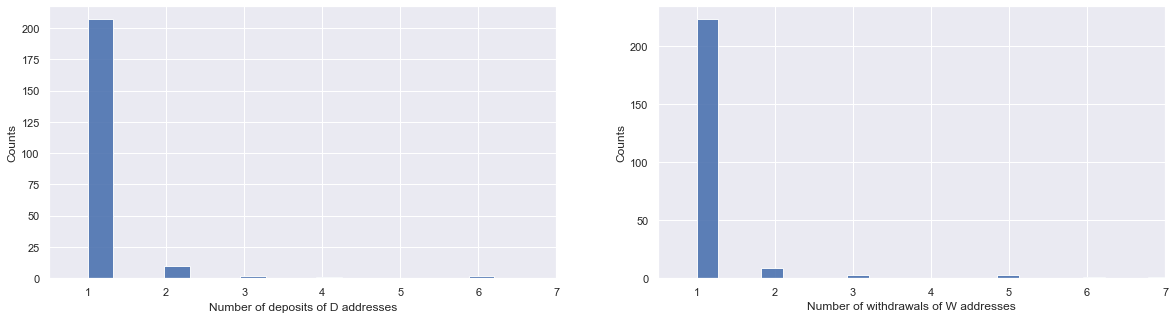

In [41]:
sns.set_theme(style="darkgrid")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
ax1.hist(D_linked_counts.values(), alpha=0.9, bins=40, align="mid")
ax1.set_xlim((0.5, 7))
ax1.set_xlabel("Number of deposits of D addresses")
ax1.set_ylabel("Counts")

ax2.hist(W_linked_counts.values(), alpha=0.9, bins=40, align="mid")
ax2.set_xlim((0.5, 7))
ax2.set_xlabel("Number of withdrawals of W addresses")
ax2.set_ylabel("Counts")

plt.show()

In [42]:
D_linked_addr_counts = get_number_of_linked_addrs(total_linked_txs, "D")
W_linked_addr_counts = get_number_of_linked_addrs(total_linked_txs, "W")

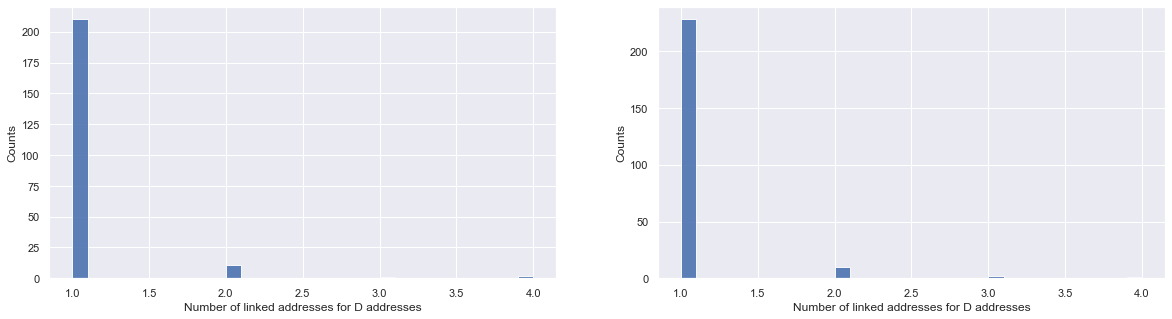

In [43]:
sns.set_theme(style="darkgrid")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
ax1.hist(list(D_linked_addr_counts.values()), bins=30, alpha=0.9)
ax1.set_xlabel("Number of linked addresses for D addresses")
ax1.set_ylabel("Counts")

ax2.hist(list(W_linked_addr_counts.values()), bins=30, alpha=0.9)
ax2.set_xlabel("Number of linked addresses for D addresses")
ax2.set_ylabel("Counts")

plt.show()

In [44]:
def get_block_number(total_linked_txs):
    
    blocks: list = []
    
    for link_type in ["D", "W"]:
        for addr in total_linked_txs[link_type]:
            for tx in total_linked_txs[link_type][addr]:
                for tx_tuple in total_linked_txs[link_type][addr][tx]:
                    blocks.append(tx_tuple[2])
    
    return blocks

In [45]:
blocks = get_block_number(total_linked_txs)

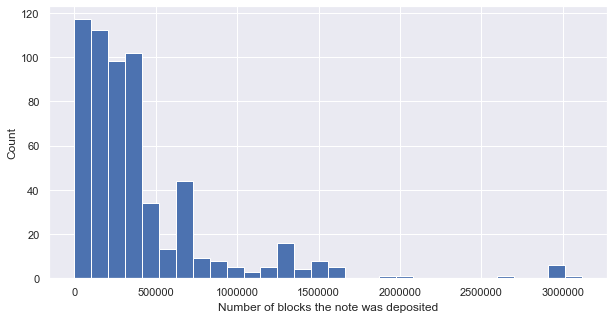

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(blocks, bins=30)
ax.ticklabel_format(style="plain")
ax.set_xlabel("Number of blocks the note was deposited")
ax.set_ylabel("Count")
plt.show()

In the previous version of this Heuristic, we assumed that the users necessarily withdraw their anonymity points (AP) from addresses that either was used to deposit to TCash or it was used as an address to withdraw from TCash. From now on, we lift this assumption and think of the AP point miner transaction as a fresh address. More precisely, it did not make any deposit or withdraw transactions to any of the TC pools.

In [47]:
def not_D_not_W_type(address):
    return (not (address in unique_deposit_addresses)) and (not (address in unique_withdraw_addresses))

In [100]:
print(len(recipient_addresses),"addresses have been mining anonymity points.")
cnt = 0
freshAddressMiners = []
for k in recipient_addresses:
    if not_D_not_W_type(k):
        cnt+=1
        freshAddressMiners.append(k)
print(cnt,"anonymity miners used fresh addresses to withdraw their rewards!")

1758 addresses have been mining anonymity points.
303 anonymity miners used fresh addresses to withdraw their rewards!


In [84]:
deposit_txs = deposit_txs.sort_values(by=["block_number"])
withdraw_txs = withdraw_txs.sort_values(by=["block_number"])

In [135]:
poolToElapsedTime = {key: [] for key in mining_pools}
deanonymizingFreshAddressMiners = {key: [] for key in freshAddressMiners}
elapsedTimeToHashes = {}
cntr = 0
allBlocksInPools = []
for minerTx in w_miner_txs.itertuples():
    print(cntr,minerTx.hash)
    if not not_D_not_W_type(minerTx.recipient_address):
        continue
    blocksInPools = []
    cntr+=1
    for pools in mining_pools:
        blocksInPool = ap2blocks(minerTx.anonimity_points,pools)
        if blocksInPool%1 == 0.0:
            
            if blocksInPool not in blocksInPools:
                blocksInPools.append(blocksInPool)
                allBlocksInPools.append(blocksInPool)
    anonSetSize = 0
    for deposit in tqdm(deposit_txs.itertuples()):
        for timeInPool in blocksInPools:
            rslt_df = withdraw_txs[withdraw_txs["block_number"] == deposit.block_number+timeInPool]
            rslt_df = rslt_df[rslt_df["tcash_pool"] == deposit.tcash_pool]
            if len(rslt_df)!=0:
                anonSetSize+=len(rslt_df)    
    print(minerTx.hash,anonSetSize) 

27it [00:00, 263.84it/s]

0 0x3a22fe99fd6c27b507760cb20a1d3ffae9ccd320dca8568d81bc47d9b7212a8c
0 0x3331a615c119a9958b4429e0789674d5219aa16f23d5e8f3f4494a713cf19385
0 0x5097c46458696ec07fecf989c60cfb26ec37eabc37348730ffdad97fbef180f4


96137it [05:06, 313.19it/s]
32it [00:00, 317.90it/s]

0x5097c46458696ec07fecf989c60cfb26ec37eabc37348730ffdad97fbef180f4 0
1 0x78b487413b9996ff504bf24b7ee4109f4e74acd3f66d7058e4d8baba3b7d57ab
1 0x30d9b4b39ab002d6f655d2a4fc2c158c2bf599eae7b4d59b895ecd0bef9b9d91


96137it [05:29, 292.12it/s]
42058it [00:00, 212155.76it/s]

0x30d9b4b39ab002d6f655d2a4fc2c158c2bf599eae7b4d59b895ecd0bef9b9d91 0
2 0xae7343da2323137ceaef2be580f9f31e9eda0e6066988acbb8d1e8bde487f003


96137it [00:00, 208073.55it/s]
20956it [00:00, 209549.21it/s]

0xae7343da2323137ceaef2be580f9f31e9eda0e6066988acbb8d1e8bde487f003 0
3 0xda59d6e7bf134d90fa8c4ee1e5da1ed6b737b0674c975e0dda660c6044bd5f3e
3 0xb09f2ef3b9224372c6284fa29b8e1e4a091496215b6f439352948c3c50ace3b0
3 0x6fca793cec0ca4eaeeb9d0585cbdcfc3ac0b75e98ffdb54bc040399eb42f4ced
3 0xd5c83db4e3bf91dd8c920f9899ebbda67cd62e5b8bf0e879ef04f7658ee13bac
3 0x582530cfbc2e991c07962e455a175c7469f81ef1ef2d974b6667cd11995dc435


96137it [00:00, 215027.65it/s]
8it [00:00, 76.10it/s]

0x582530cfbc2e991c07962e455a175c7469f81ef1ef2d974b6667cd11995dc435 0
4 0xa8533bb7403e1a3aaaf22eed41454b31bf0c6d5be4265cc7000097bc4d9bb4c6
4 0x4499f66f5eaac327a6e17cc97634a6af7a1f47919f406169d8e8aa209f55f620
4 0xbaefb0f7390c676bfac8e5a2d4320a28eeefe546d00fe78aef2e4e25795bfe30
4 0xba9b5330c6655bd03171ea6709fe58e82014f92c735d1ffb71b451b506b46404
4 0xb941e57dcb964d5597ad06367ff3301648cf13dd1f5b53c601a24943f362a5b7
4 0x7a2ccbffc1bbde323ee8a4b85f58dc7f090e700604adede764729b39567aa7e3
4 0x77a5b5fdb43ec0a5e8d0c6f10117ac0c94bd2b225ac7598916385c19a1844c49


96137it [18:38, 85.95it/s]
66it [00:00, 330.53it/s]

0x77a5b5fdb43ec0a5e8d0c6f10117ac0c94bd2b225ac7598916385c19a1844c49 721
5 0xc3683ffc8e8b94b1d85fd9f647bdf6578cccf14591f2546968be6ea26eab5acc
5 0x7a04675d3fdbdc9931e8dcb8e4a6f54f4c94c12f83df8f21b9a855b8a554af35
5 0x82cf6b53dee4eae8ff844cf9b546633e1eaf3bb60a31d5f44b2e9384eee95bff
5 0x47a738adfc8bd31459f16fdb137538ce7f6428cecd66da2e8841907a9051261b
5 0x844aa1255e34684c4d59862d20d87994cc271d972827005b9ccc6c4b376d7a90
5 0x5feab386bf2314e330b0431df5edfe6e8a74880587d15e7fffa2e4d520dbd313


96137it [04:29, 356.10it/s]
5it [00:00, 49.30it/s]

0x5feab386bf2314e330b0431df5edfe6e8a74880587d15e7fffa2e4d520dbd313 347
6 0xcd65c9afeb130d90728f4ca159c0f57a846c1798519d204958e99fa661037fe2
6 0x16e200cb174763bff3179975d4be8de61250a3b5dfd21c67c553aca3d859e541
6 0x9f7acb2782f45f0fe9805eafd9eaa4e10a3fa52a854eab26a0c4032aa29ac55d
6 0xf22305a55f16670af9aba7e25f6665752bbca57bbe0c884e7bac8abd60f8c915
6 0x0e05c26a8930869b9417d992b7e07974e84016e7eb05cb966a4dc94b5f68a863
6 0xdaa8a50003a7cc7f4605ef0bff71616f5baf3ad8d8e39a8ebd261d5a07d35d25
6 0x6013462532d85fc42bc2bf5539404ba5a7ca40248597b389b86b01048deeed2c
6 0xf54b5d1d8125d699efe31320099604a403dcfdc05c959b54f76092badddee510
6 0xefd21848d8186b1bd497bab135313b5eae2b44b59414606bdf4375c7eee2dfa1
6 0x5b9e8841c40ff40d116b132aad37eda74d38b79f676c4287b1ce771da40f476c
6 0xd76b60acd2bf243413244409e279ecf723f12efc16fe20aab9df836227c4df15
6 0x6de313838205e22b91665e96603bffa02d1d9a7e177b8286efce4acbda949ce7
6 0x88d384f0bc72fc7e0adffcc059b1fbd7de74a4c3c701e11a0128093802f1fd6d
6 0x4a5c95dabbac40b41bcad92c7bc8

96137it [24:33, 65.23it/s]
7it [00:00, 68.63it/s]

0x7d4821d4a5aff8eee560d2a0f1e512b6c04cdef980fe43cdf72623a5e460502c 3118
7 0xc25be02e2fe7d62df8d9f6b0bd42a2022f4f00521608aad75cd624bfa516ab23
7 0x6783a405d566a10eb704b2be9621202e310b612c9056a995af864c2e873868e6
7 0xc468d75a7a9a35de74dbb62106b52a97d29c94229148c116f0c70e1967fa5fda
7 0x58a6fbf6b3d35068e35d5e9bba66c292428ec177a949db01206f24539eebcd3c
7 0xca9c7211243cdd0e29806d50c94090b32394094b2e736e4a90243680434b0b31
7 0x90f4ab8e5f659723c30d8521fd4a70bf511a9d82ccfe205c56fbc4e36423b59d


96137it [19:56, 80.32it/s]
21418it [00:00, 214164.38it/s]

0x90f4ab8e5f659723c30d8521fd4a70bf511a9d82ccfe205c56fbc4e36423b59d 3949
8 0xe854b6e8ed2671c8059334a657eda022ef2f0c304b763b8f2b0a25a6e95c03dc
8 0xbec0218a9079116c5b4eaa51771d12cbb76de4a9cae3943f7b5a982e3ed2227e
8 0x4e6178e142ce67ea7dae6738889f8a5cc51452ca71cb330d409a7e956e4248f4
8 0xe61aa127c3c1fdc1ac4ad48c266cdbadfeaf9e1e410775e182598cb2272fee06
8 0x984957a4ffa7a1e74bd1eab99f762ba828b0bd4daaaa428fd4183bddf48568a8
8 0xbd48a37ed5fa4563a7b80b0252dadd4c2551ef64fceb878b8f9a00b624426a79
8 0x343d084e669392af81ef5a0c99269d7aefd9bf9a0d650dfcbde1e92589741d15
8 0xacc33bee9b05483b28d76e15ceffed8e2610c67c1fd45aca6443eeef15001bb7
8 0xfaa49c66b80b3bca8f4bd3a285250ed1d97825e2062496bae319c2b31ef54bf7
8 0xb3b545d64397346f1a62027314a2d2155e95a1663e8e45d05532ae1520d8c2d0
8 0x4522389fa60e4739401197ad32c82c1f6ca7f1d1f450b83fa738bdbe4bbabfb3
8 0xa45f89f7f5dc4196b2e5ca11baec4167867f043f82a17deb148ac9dd98f0206b
8 0x431b31dcf4d38f3e1f54349830e9ea5452585f6cdcb6b5a7ca25c95f50feb2c2
8 0x639df3670d9e77db8aa5da249b6

96137it [00:00, 207374.03it/s]
27it [00:00, 263.75it/s]

0xfbd4190497d0c26465ba2fd6844e1cfe4a9c5e6551bf2609a09b6db0102a88b8 0
9 0xf76bf2edafe5e68554f703ec218102fe4cb164958330d34f50c30e96d9faf518
9 0x40a51917b391fef85105c6a04c6b58ce74e2f556ec8c77a1251eb308f8b6979e
9 0x5af52b2649556ddff72834d6d11565a0b3952fddd0d0d815325fba9555e2e2f7
9 0xd338013246d325d9394ac045ebfdf614161026f29d3b2c6831074cfa0c16102a
9 0x8a9fb37f37ef4dbb9e5cec7a570315572649af11d3b99a6fff116f476af18009
9 0x3d91f734d78994b176ed225bdc9415669d0d6844b88d8538ec2e513e18160b5e
9 0xcfd794c84fa4b16fdc8cd9809938ff244b9cfc897d683e35d212e784ee5fd6ff
9 0x1c5b8c3f8dfe05ff573b07c12dc297c903bbbd25bab7c52b9db0015fd2761707
9 0xaf2c200629f046c3f7adea899557da538f43ba1c75e084949a5e61f63bec5092
9 0x63343c3fe2600203c48a46ba8582c6ecc1a072430478ccf4726c14d8b2c5d455
9 0x6a89c22d74a8e8a8546de4d8017c3da8ea1efa3cb44923dc455aa8b872bcf400
9 0x7ba8a63ae430052b88f3f1f51e69b982bc11d8b58fcca8407fa34c732c1e7ce5
9 0x4a116a894ea48022c04478b6ac8b8352e1b82bd655a498935f1fbb82b362731a
9 0x4fddb7a151c6d2963dd36f2042fc49

96137it [05:12, 307.74it/s]
30it [00:00, 293.50it/s]

0xc784bbbd21ec3e0fa19b5d7f6e20ee0e4a52aa1fe65fc96e27bef3f2a9d09c0b 766
10 0x198df6a9cab02fc0df2916f802d4a072727edc186cd2cef614a25f67a7f7358e
10 0x1de01ab3a0f948dede1bf7d6f7958da7aa46303e7b31e50f92153d3333ac8fe1
10 0x2a39432c8e38cb04ae591a4ec2359f27db9fa0c923a29c45b5ead288eebf4eb6
10 0x596785d130a93a64d791f5b511856c78df9e99a9d96a08ed5df1ffaec332b445
10 0x2685875aef9be855a127f3711d3be0f53f7b54bec789ff788e72b30654700e7f
10 0x7b9c93a3a1958677b3ee8fbaf247fa75e8bf704e954ebff62188908d71b5129a
10 0xc44a93227d6cb5f47857f14f008262a618645a1a941098e6ef23c5b5bf8979d4


96137it [04:53, 327.90it/s]
27it [00:00, 265.85it/s]

0xc44a93227d6cb5f47857f14f008262a618645a1a941098e6ef23c5b5bf8979d4 0
11 0xb656f382ca4bde57ef26675d339f2be1c4ccdc57fa0dcd3804fc8b90ac91327e
11 0x9760e48b649cc4e83ea3365421bb338e24f262c3480892e81d4bd4cb868e08d1
11 0x530edd068ea39234ccb397ad919ba323e9e3ff45a8f62530a89f28ea30d48444
11 0x973529edf9a5f577ae77e90dfd580d7f13beb9e26717fbd64cc86023386df0f1
11 0xb5faa358cc2689a5f3d1d72a9ff92c08b531e6fa96409e6e32a5224e6e0a788e
11 0xca989b1a4bd09a899224086da4e452d3320793fa644d0af07721ee3191c71ade
11 0xc5fd771a88a8b63563b3146840fa595ad98fe85b54ad7b525e25916a4f1317d5
11 0xbf5a03d8c19d30a83346a0a30decf1b1e42d0b020ab8537b46df2994d224c10a
11 0xd2102eb738ebce2397c8aeebd3ba57cba394e857c967878a797c9dc737f992a3
11 0x8481ff21bbf83aa4af016be6d2d913e246259ae072b1b700958303157d499252
11 0x6d25fe2136b2f70c80ab7471ec3f265cc6191bb29c019cd1fa4b975f3163f65a
11 0x29bf1ce2c9f660fb09a80105f26f048dacf89fc26772197867b5d0f1020ae6da
11 0x4bc33edc83966b6295a22d27e1cdb131d197c7256346b7d9659c3f9dfa9da8ef
11 0x83faf7b6cf268d98

96137it [04:39, 344.33it/s]
8it [00:00, 77.11it/s]

0x4b85cc83910d4dd51005391178adc0f3bc8733b58b76daea04addddac22ffb32 1135
12 0x986c517dd908b087dfb48b005428975b91a3393d378b8eab083278c26d151e6c
12 0x5f8ff09d0717e78e26c50261957b1299dee4c9b86632b6cf17c9c630a19f05fe
12 0xe663c9f86a6d41d41a7c70ce6cc1bb5563f64a0801ccf9c89a69fd122a146797
12 0x351fc4fc2f2acd175f148389506609c0689792399c9aca2f03889488024b20e5
12 0x3b83396748410152c83c1cf942a57f858c98e5fe2b456497b3219aee3fe94bcb
12 0xb4e53b8d384ed1b93da0eec46507fb17b24832596508c47c74b3561ecb9e469d
12 0xe4e61be8dffccd4983221d475392742cdd1ae77a5615a81e6a8fc46aa7bbb555
12 0x6750b9812a9fb729ec86f5c48e936516808b878cff6356561a58db8ad3c69aea
12 0xdcb92ce3b5c6218892bb50efe7128e0affaa657c0dbb57bdb66a036d14ed96de
12 0xa959944a0c183e8325c4279e03a547b10d7d5ab354a2c3817f563d82c318a439
12 0x7bbd2ccf7f431f846aa0626790820f9ec646d27d5d6c2adaa4fb9980cd60f8ba
12 0x2833b65dc6dcbe3a7a291e1ff87b3a691e088ef5425d18d76d78226749c73b03


96137it [17:10, 93.33it/s] 
56it [00:00, 556.36it/s]

0x2833b65dc6dcbe3a7a291e1ff87b3a691e088ef5425d18d76d78226749c73b03 2631
13 0x9c2e8761fbbe8ae50e444ca74c26d6870519edf3dbd90f5724172a2f9786e826
13 0xacf6d14377903f9ea7c5807869a005ded9eab68b26df590cd67852a859dadae9
13 0x6f2b08d31d0333baa82576e0bbbd2d5dc2f5a47851845762cf0528e75d6594e2
13 0x1b646693ca678690d8234a2538b139c351c857184c9a2389922f2d6f782c7d2b
13 0xb3460defa44cc7a3fd2845af804005a60f28998a34eb81cdfb7298d78ba7e007
13 0x6bbdbcc0680cbb0d52afa5a80c3af791099c1d7ba888504ce50759be8c413aa9
13 0xd880245d1ffe8c7c35ff6cdc0ddd80e09bace4fb2e97c1a759924bb6349ecc3a
13 0xa487c3295f504b88f862435c4e87a0ba85af74832fcd3ff4a44e9fa3081e9d2b
13 0xd6a0f7883d118a6c55b5d39abb608fdfd70da21abd87607801c909015aebda75
13 0xb777e0feb7ff9cc9e50c847e4903b9fc7d8a596de584683725f5e80025a4c28e
13 0xe0a482f3601d94042167fa0d7d656e4ec959ea7382871e5db53b0e56577182f2
13 0xf9edf2f6107bd9a618b0779cef859583137579fc5f4a133fc4ee0f8d5f913859
13 0x8db14f415ef6de2508e438c56dedad9b321d31ff7d4eb7db6f81ab18ebd8a5a1
13 0x7d3c846448dec

96137it [02:23, 670.82it/s]
41719it [00:00, 205822.90it/s]

0xaaba89e3f21c1f4e5771df45bb0fb768e501f718adb4571cb80916211d5914d1 0
14 0x3a8f971eefbdd4aad320e582af5773c92ed3320eafbfb3b80d3ba8e4d20edfe7
14 0x79e08b5eb06ee10c7d6047d2957c153ea777dfafc005d595c95b10e772b09e72
14 0xecaa377b58bf4019393a31e283575f977db7caf70c03a27953b3e831b9e19630
14 0x707229c9e0292127470b162008235c3279380fdc8d66c8ccf7dc44ba41aabb26
14 0x98df06264bede129abaec96cb4eef352c7ca3e5b868c113f4cafae3c01b15a94
14 0x0a10512b387b809c08fac75d962587b12b8e7d86d7f98290f39fd383fbc6d7f3
14 0x820284ead4587ae9b2846415ec95f0bb784ba7210fa9d492ea43f4175ffd4d16
14 0x16865c0d77c5b63eeae908963cc21e6d3e5d4eb5c09ff9f4b6e02b4e006cc114
14 0x894c7613fbbed653dd0e0900ecabfe4f5391d235ac70c864358907e998bee988
14 0xdda5049d182872445a4577e58e337f059cce39c27caabccbb6a0df25383ae420
14 0xe7138b4a2fdfc6784f71c672778b9981fa34f0ba97ecfd491e25a8243fdef9e5
14 0xb476d988a4dc64e680df74b251f361e469de24b8af52df47608d902f31bead4d
14 0x85c673b87937fa51cf869b4fc4df28992578e62f98248c0911b9635a34f7c6b5
14 0xf8fee8582dcf21ec

96137it [00:00, 209276.02it/s]
42411it [00:00, 213447.95it/s]

0x78a1fa8ff094bf3e587a5e7ced1321577a158109bf2c0167bdd5027dc6d47ac4 0
15 0x6b93d44dd4183d41304060e35920f9b540cc1221401aa5769cfd63c1f5ea135b
15 0xf13b9b198b5b97e2b83f5290b220f0112db7464829d52cefc159fe0779e55786
15 0xe1f556b629eaaaa7b55acab7afda403b2fd50a57697d387333a521dc14f344bb


96137it [00:00, 217043.53it/s]
8it [00:00, 78.42it/s]

0xe1f556b629eaaaa7b55acab7afda403b2fd50a57697d387333a521dc14f344bb 0
16 0xcfca9af6e330ec18589bfb7d55076b54e3944f2f8abf12981edf9a1a2fe8d2cb
16 0xdd93f9e8a2faf3351c5421e042c9c8d3cda72e29b515016cc8f17efaddbb4a7e
16 0x2a14b38792cd2a53134e5fd778e048dbd508398ec387164236292409dbf39369
16 0x7f699b7cbb54cabb8aa3ae0c5b6af1383289d8fbabb623afc31ea016c332d8e3
16 0xc0ddb92b8503918e27a690a6aed0d703a537af64c7632bb359cc0d594d21e973
16 0x69ae2c3aff4046c2ab4f4d8c6d4aeb223bb1efc7ac50e1b79903a1ed299b2706
16 0x507d697bf67d50fd64ba894e55b855616dfb7ff9b6b0cb0467b53404e628b696
16 0x5e81e6973cb80e988ac0e8ccc1506062ce88053e3f0ae79e69cab03ef27f5b8b
16 0x5ff3cc22811448c103f1862e6e76b72eca52ace01b4d221871892be626aa078f
16 0x606f3db1742ec3c8de46b80ca7ef563cfe5716e3cf294741723f2f055b652977
16 0x4f6ca62748a37c2b248bbbcdfe3d7df1cd5d9e507df041fcdbf4bc902f92767e
16 0x286fe01ef99d00041baba9ef93f78ed497c7843494c4dcc868c0f2d77cbf1cc2
16 0xd52f3330759a317aee1062f8ffe054ef5556504e4b5b053b93e8ba58e520d3fc
16 0x88d77a40830a92f4

52548it [10:01, 87.33it/s] 


KeyboardInterrupt: 

In [116]:
allBlocksInPools.sort()
print(len(allBlocksInPools))
print(Counter(allBlocksInPools))

1700
Counter({28297673.0: 9, 56595346.0: 9, 188299103.0: 8, 30426.0: 5, 101420.0: 5, 243408.0: 5, 304260.0: 5, 608520.0: 5, 811360.0: 5, 1217040.0: 5, 3042600.0: 5, 6085200.0: 5, 8000000.0: 4, 8079279.0: 4, 16158558.0: 4, 20000000.0: 4, 29350551.0: 4, 34541149.0: 4, 60621413.0: 4, 18575.0: 3, 92875.0: 3, 182973.0: 3, 464375.0: 3, 609910.0: 3, 1235289.0: 3, 1463784.0: 3, 1523582.0: 3, 1829730.0: 3, 2321875.0: 3, 3659460.0: 3, 3808955.0: 3, 4117630.0: 3, 4879280.0: 3, 5000000.0: 3, 6176445.0: 3, 7318920.0: 3, 7617910.0: 3, 18297300.0: 3, 19044775.0: 3, 30000000.0: 3, 30882225.0: 3, 36594600.0: 3, 38089550.0: 3, 40000000.0: 3, 100000000.0: 3, 200000000.0: 3, 11000.0: 2, 13903.0: 2, 23442.0: 2, 27500.0: 2, 31727.0: 2, 33286.0: 2, 34127.0: 2, 44000.0: 2, 58605.0: 2, 62700.0: 2, 63085.0: 2, 69515.0: 2, 93768.0: 2, 99858.0: 2, 101804.0: 2, 125156.0: 2, 151404.0: 2, 152594.0: 2, 156750.0: 2, 165000.0: 2, 183262.0: 2, 184050.0: 2, 189255.0: 2, 195350.0: 2, 199716.0: 2, 214431.0: 2, 220000.0: 2,